#Library:

In [ ]:
from os.path import isfile
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras
import random
from keras.optimizers import SGD




# Getting data:

In [ ]:
# For classification
data = pd.read_csv('/content/data.csv', names= ['path', 'class'])
df = pd.DataFrame(data = data) 
df.head()



# shuffle the df to avoid overfitting situation
df = df.sample(frac = 1)


# drop 21st row bcz it consist of NaN values
df = df.drop(index = 13)
# df = df.drop(index = 0)

# print(df.shape)  #for verifiction


# making the class values to int instead of float
df["class"] = df["class"].astype(int)


# train and test data
train_data = df[:8] 
test_data = df[9:]

# For reference [not needed now]
classes = {0:'mouse', 1:'box'}

test_data


,path,class
4,/content/Frame(77).jpg,1
1,/content/Frame(29).jpg,0
11,/content/Frame(98).jpg,1
0,/content/Frame(28).jpg,0


# Model Building:

- Using MobileNet architecture. and combining custom top layers.

In [ ]:
 
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1


# Build base CNN layer EfficientNet using Keras
def build_cnn_layer():
  
  cnn_layer = tf.keras.applications.MobileNetV3Large(
    input_shape = (224,224,3),    #change input size if needed
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    include_preprocessing=False )
  

  return cnn_layer


# Build Dense layers
def build_dense_layers(input_image):

  x = input_image
  
  # Dense Layer
  x = Flatten()(x)
  x = Dense(24, activation='sigmoid')(x)

  return x



# Build classification head layer
def build_classifier_head(input_image):

  x = input_image 
 
  # for multi class very important to give name to head layers[class & regressor], with thier name only we assign loss while compiling.
  classifier_head = Dense(2, activation = 'sigmoid', name = 'class')(x)   # have classify only 1 classes

  return classifier_head



# Build regressor head layer
def build_regressor_head(input_image):
  
  x = input_image
  
  regressor_head = Dense(4, name = 'regressor' )(x)   # have 4 bounding box location to predict 

  return regressor_head




# Combining all the function

def final_model():

  image_input = tf.keras.Input(shape=(224,224,3))  # passing input shape necessary in functional API

  # [FOR CUSTOM CNN LAYER]
  # #adding cnn layer
  # base_model = build_cnn_layer(image_input) #build varaible to store the function returned value
  # x = base_model    #input the data in base_model using functional API mtd

  # [FOR TRANSFER LEARNING LAYER]
  #adding cnn layer
  base_model = build_cnn_layer()   #build varaible to store the function returned value
  x = base_model(image_input)      #input the data in base_model using functional API mtd


  # adding dense layer
  x = build_dense_layers(x)


  #adding classif head
  classify_head = build_classifier_head(x)


  return  tf.keras.Model(inputs = image_input, outputs = classify_head)





# calling the final_model()
model = final_model()


model.summary()  #checking if everything is okay 



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_5 (Flatten)         (None, 47040)             0         
                                                                 
 dense_2 (Dense)             (None, 24)                1128984   
                                                                 
 class (Dense)               (None, 2)                 50        
                                                                 
Total params: 4,125,386
Trainable params: 4,100,986
Non-trainable params: 24,400
____________________________________________

# Data Generator(instead of Tf dataset):
- Using data generator instead of tensorflow slice dataset.map().batch() as input for model.fit()

- Motive for datagenerator is to increase data for trying to improve the accuracy. 

- Work Progress:
1. make Sample function() --> to gather (image_path,label) into list of list.
   Eg: [[image_path_1, label_1], [image_path_2,label_2],...]

2. make preprocessing function() --> to do any sort of image manipulation(resize, normalize,..etc), converting the path to image also convert label to categorical values and return img,label.

3. make generator class(keras.util.Sequential)--> used keras.utils.Sequence.
- __init__() to initialse all the x,y,dim,batch_size stuffs.
- __len__() returns steps_per_epoch = len(dataset)/batch_size.
- __getitem__() returns array of images and lables in keras.util.to_categorical format in batches.




In [ ]:


# preprocessing function()
def img_preprocess(path, label):

   # read the file from the path
  image = tf.io.read_file(path)

  #now to decode the file from previous readfile because it read the file and stored it in Machine language now we have to decode it 
  image = tf.image.decode_jpeg(image, channels=3)
  
  # image resize
  image = tf.image.resize(image, [224,224]) / 255. # EfficientNet needs this size
  
  labels = to_categorical(label, num_classes=2)  # num_classes are 2 ->(box,mouse)

  return image,labels


########################################################################



class DataGenerator(keras.utils.Sequence):


  # Generates data for Keras
  def __init__(self, x, y, batch_size, shuffle=True):
     
      # Initialization
      self.batch_size = batch_size
      self.y_data = y
      self.x_data = x
      self.datalen = len(x)

      # self.shuffle = shuffle
      # self.on_epoch_end()




  def __len__(self):
    # Denotes the number of batches per epoch
    return int(np.floor(len(self.x_data) / self.batch_size))




  def __getitem__(self, index):

    # making batch_x
    batch_x = self.x_data[index * self.batch_size:(index + 1) * self.batch_size]
    

    batch_y = self.y_data[index * self.batch_size:(index + 1) * self.batch_size]

    batch_data = [] 
    X = [] 
    Y = []

    # zipping the the batch x & y side by side. 
    for i in zip(batch_x, batch_y):
      batch_data.append(i)
    
    # for each item in batch_data of size 2
    for item in batch_data:
      img_path = item[0]
      labels = item[1]
      
      # now bring 'img from path' and 'label as binary matrix' 
      img, label = img_preprocess(img_path, labels)

      X.append(img)
      Y.append(label)

    
    # model need np.array
    return np.array(X), np.array(Y)




# Compile and Train model:

In [ ]:

# SGD(learning_rate=0.01)

#compile
model.compile( optimizer = SGD(learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'] )

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_5 (Flatten)         (None, 47040)             0         
                                                                 
 dense_2 (Dense)             (None, 24)                1128984   
                                                                 
 class (Dense)               (None, 2)                 50        
                                                                 
Total params: 4,125,386
Trainable params: 4,100,986
Non-trainable params: 24,400
____________________________________________

## Train model:

In [ ]:
batch_size = 2
x_train = train_data['path']
y_train = train_data['class']

x_test = test_data['path']
y_test = test_data['class']


# model training
model.fit( x = DataGenerator(x_train, y_train, batch_size),
          validation_data = DataGenerator(x_test, y_test, batch_size),
          epochs = 20)   


Epoch 1/20
4/4 [==============================] - 2s 634ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 2s 625ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 2s 620ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 2s 646ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 2s 580ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 2s 632ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 3s 627ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 8/20
4/4 [====

# Predicition Phase:

In [ ]:
# class
classes = {0:'mouse', 1:'box'}


def predict(path):

  #### READ IMAGE ####

  # read the file from the path
  image = tf.io.read_file(path)

  #now to decode the file from previous readfile because it read the file and stored it in Machine language now we have to decode it 
  image = tf.image.decode_jpeg(image, channels=3)
  
  # image resize
  image = tf.image.resize(image, [224,224]) / 255. # EfficientNet needs this size
  
  # before sending the image to predict we need to resize it using np.array
  image = np.array(image)

  # model predict probability
  y_prob = model.predict(image.reshape(1,224,224,3))

  print(y_prob)

  #### PREDICT ####

  # cal max prob
  max_prob = np.argmax(y_prob) 

  # predict image
  predicted_img_class = classes.get(max_prob)

  # for making cross checking easier
  plt.imshow(image)
  print(predicted_img_class)
  print(max_prob)





1/1 [==============================] - 0s 110ms/step
[[0.02096369 0.69320846]]
box
1
1/1 [==============================] - 0s 80ms/step
[[0.04316355 0.61717135]]
box
1


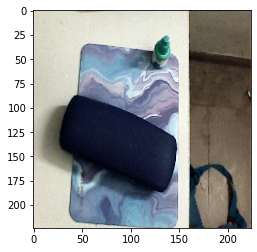

In [ ]:

# generating random number
num = np.random.randint(0, len(x_test))

# convert it into list bcz to access item using [num]
x_test = x_test.tolist()

# # call function
predict(x_test[num])


test_img_path1 = "/content/test_img_01.jpg"
test_img_path2 = "/content/test_img_02.jpg"
test_img_path3 = "/content/test_img_03.jpg"

# call function
predict(test_img_path2)



In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
